# Perform Analysis - Using out of the box tools

There are manay out of the box raster analysis tools available in ArcGIS API for Python. In this guide, we will demonstrate a few of them such as creating viewshed, interpolating points, converting raster to feature, and converting feature to raster.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-prepared" data-toc-modified-id="Getting-prepared-1">Getting prepared</a></span></li><li><span><a href="#Creating-viewshed" data-toc-modified-id="Creating-viewshed-2">Creating viewshed</a></span></li><li><span><a href="#Interpolating-points" data-toc-modified-id="Interpolating-points-3">Interpolating points</a></span></li><li><span><a href="#Converting-raster-to-feature" data-toc-modified-id="Converting-raster-to-feature-4">Converting raster to feature</a></span></li><li><span><a href="#Converting-feature-to-raster" data-toc-modified-id="Converting-feature-to-raster-5">Converting feature to raster</a></span></li></ul></div>

## Getting prepared

Let's first import the packages and make a connection to our GIS.

In [9]:
import arcgis
from arcgis.gis import GIS

# gis = GIS(profile="your_enterprise_profile")
gis = GIS("https://datascienceqa.esri.com/portal/", "portaladmin", "esri.agp", verify_cert=False)

## Creating viewshed

Viewshed indentifies the cells in an input raster that can be seen from one or more observation points or lines. Each cell in the output raster receives a value that indicates how many points or lines can be seen from each location. Viewshed is very useful when you want to know how visible objects might be, such as finding well-exposed places for communication towers.

<center>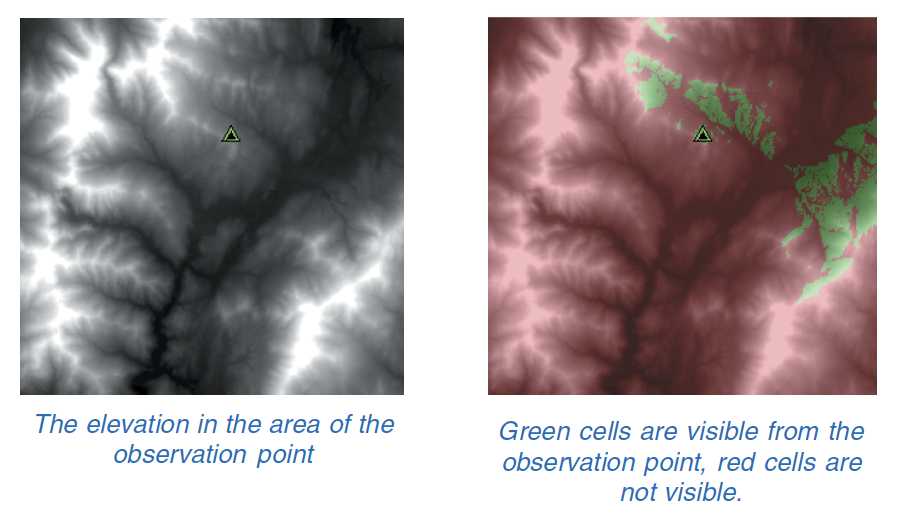</center>
<center>Figure 1. An example of creating viewshed with a single observation point</center>

In order to create viewshed, we need a input surface raster layer and a observer feature layer. In this example, we will use elevation layer as the input raster and a few points representing schools as the observer layer.

In [24]:
items1 = gis.content.search("title: elevation, owner:portaladmin", item_type="Imagery Layer")
items1[0]

<Item title:"elevation" type:Imagery Layer owner:portaladmin>

In [25]:
input_raster = items1[0].layers[0] # elevation/DEM raster layer


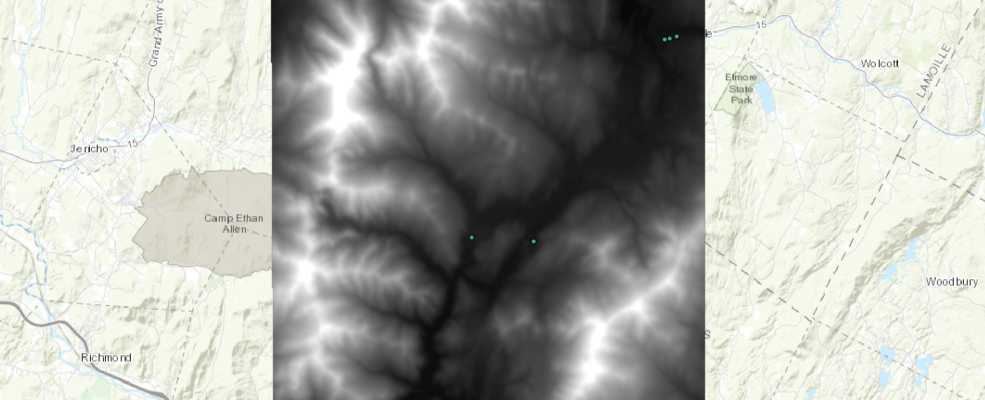

In [41]:
map1 = gis.map('Stowe, Vermont, USA')
map1

In [36]:
map1.add_layer(input_raster)

<Item title:"schools" type:Feature Layer Collection owner:portaladmin>
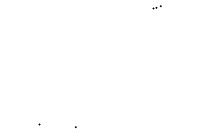

In [37]:
items2 = gis.content.search("title: schools, owner:portaladmin", item_type="Feature Layer")
items2[0]

In [38]:
observer_layer = items2[0].layers[0] # school points as observer layer
map1.add_layer(observer_layer)

As you can see, we have added five schools on the map.
Now we have the input layers in place, we are ready to creating viewshed.

In [28]:
from arcgis.raster.analytics import create_viewshed

res = create_viewshed(input_elevation_surface = input_raster,
                      input_observer_features= observer_layer)
res

<Item title:"CreateViewshed_SM2U5U" type:Imagery Layer owner:portaladmin>

Let's visualize the viewshed output.


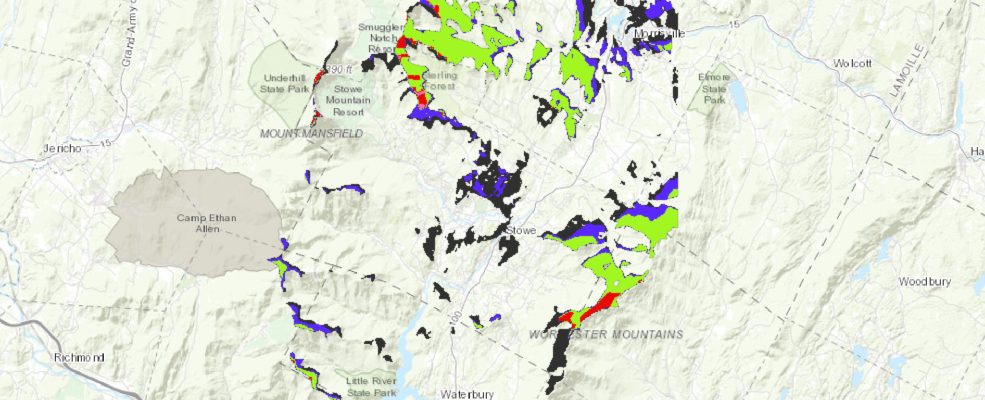

In [42]:
map2 = gis.map('Stowe, Vermont, USA')
map2

In [40]:
map2.add_layer(res)

In this example, red color representing the largest value, meaning it can be seen by most schools, while black color is the smallest value.

## Interpolating points

Interpolation predicts values for cells in a raster from a limited number of sample data points. It can be used to predict unknown values for any geographic point data, such as elevation, rainfall, chemical concentrations, and noise levels.

<center>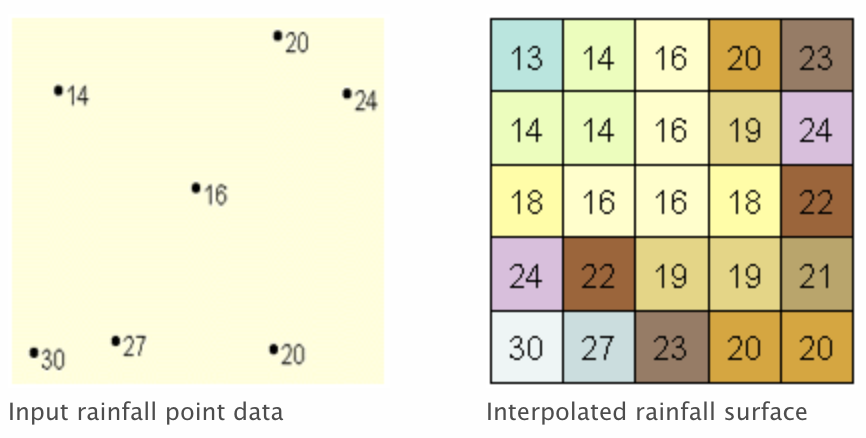</center>
<center>Figure 2. An example of interpolating rainfall point data</center>

The interpolation tools are generally divided into deterministic and geostatistical methods. The deterministic interpolation methods assign values to locations based on the surrounding measured values and on specified mathematical formulas that determine the smoothness of the resulting surface. The deterministic methods include IDW (inverse distance weighting), Natural Neighbor, Trend, and Spline.

The geostatistical methods are based on statistical models that include autocorrelation (the statistical relationship among the measured points). Because of this, geostatistical techniques not only have the capability of producing a prediction surface but also provide some measure of the certainty or accuracy of the predictions. Ordinary Kriging and Empirical Bayesian Kriging is a geostatistical method of interpolation.

In this example, we use ozone concentration point samples (measurements) in California to produce a continuous surface (map) predicting the values of ozone concentration for every location throughtout the state.

<Item title:"O3_Sep06_3pm" type:Feature Layer Collection owner:portaladmin>
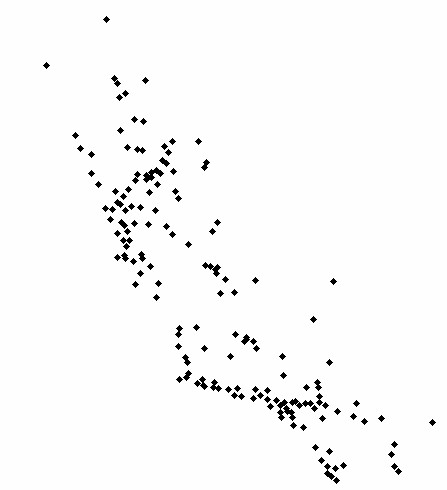

In [44]:
items3 = gis.content.search("title: O3_Sep06_3pm, owner:portaladmin", item_type="Feature Layer")
items3[0]

In [46]:
ozone_layer = items3[0].layers[0]

Now we have the ozone point samples, we are ready to interpolate these points to create a continuous surface. By default, `interpolate_points()` uses [Empirical Bayesian kriging](https://pro.arcgis.com/en/pro-app/help/analysis/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm) under the hood.

In [52]:
from arcgis.raster.analytics import interpolate_points

res = interpolate_points(input_point_features = ozone_layer,
                         interpolate_field = "OZONE",
                         output_name = "interpolation_res")
res

FunctionOutput(output_raster=<Item title:"interpolation_res" type:Imagery Layer owner:portaladmin>, process_info=<IPython.core.display.HTML object>)

In [59]:
res.output_raster # access the result item through the `output_raster` property

<Item title:"interpolation_res" type:Imagery Layer owner:portaladmin>


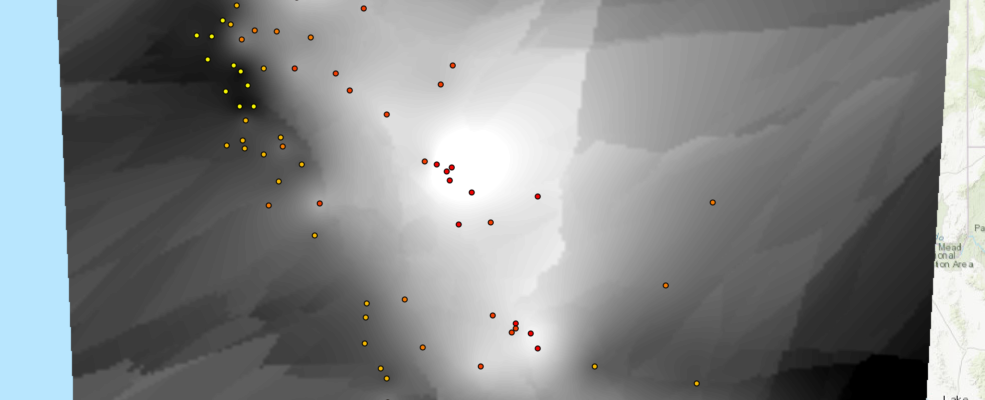

In [62]:
map3 = gis.map('California, USA')
map3

In [61]:
map3.add_layer(res.output_raster)
map3.add_layer(ozone_layer)

## Converting feature to raster

## Converting raster to feature